# **Histopathologic Cancer Detection**
 <br> It is common noawadays that people are only aware of having cancer only when they are already in stage 3 or 4, which could be too late to start treatment.
Hence our team wanted to come up with a solution **to detect cancer with computer vision models with high accuracy** . Due to the low cost and fast prediction, it maybe can use like a **reference before actual cancer test** at the hospital. It can make people **more aware** of **early medical examination** and **not hesitate** because it is **much more cheaper** than actual one</br>

Data set that we use was to large to submit, we have attached the train_label.csv and word file contain links
<br>Link of the [dataset](https://www.kaggle.com/competitions/histopathologic-cancer-detection/data) that we have used</br>

In [1]:
import os
import math
import pickle
from tqdm import trange

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from datasets import load_dataset, Dataset
from datasets import Image as ds_Image
from collections import OrderedDict
from PIL import Image
import torch

# 1. Exploratory Data Analysis

In [2]:
df=pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')
df

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
...,...,...
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6,0
220021,d4b854fe38b07fe2831ad73892b3cec877689576,1
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75,0
220023,f129691c13433f66e1e0671ff1fe80944816f5a2,0


In [3]:
df['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

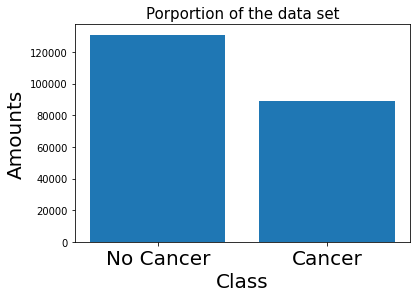

In [4]:
ax = plt.subplots()
y = df['label'].value_counts()
labels = ['No Cancer', 'Cancer']

plt.xticks(range(len(y)), labels, fontsize=20)
plt.xlabel('Class', fontsize=20)
plt.ylabel('Amounts', fontsize=20)
plt.title('Porportion of the data set', fontsize=15)
plt.bar(range(len(y)), y)

plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['font.size'] = 9.0

plt.show()

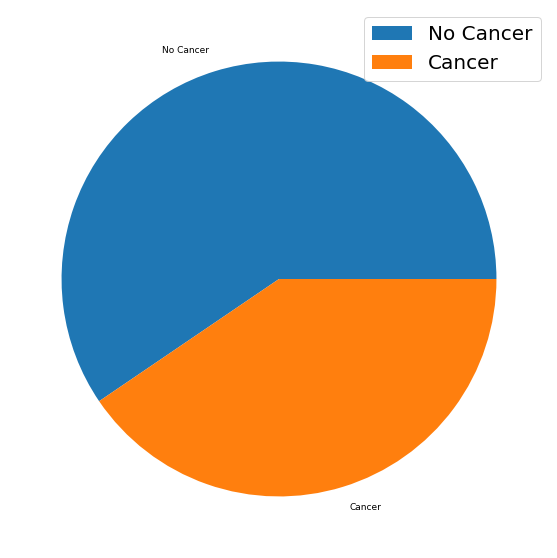

In [5]:
plt.pie(y, labels=labels)
plt.legend(fontsize=20)
plt.show()

# 2. Data Pre-processing

### 2.1. Create Image Path from `image_id`

In [6]:
df['image_path']=df['id'].apply(
    lambda row : '../input/histopathologic-cancer-detection/train/'+ row + '.tif')

#Choose 10_000 data points from the data set
df = df.sample(10_000)

In [7]:
df['image']=df['image_path']
df=df.drop(columns=['id'])
df = df.rename(columns={'label': 'labels'})

In [8]:
# import os
# os.listdir('../input/histopathologic-cancer-detection/train')[0]

### 2.2. Create Image Object from `image` ( `image` contains the image path )

In [9]:
dataset = Dataset.from_pandas(df).cast_column("image", ds_Image())
dataset

Dataset({
    features: ['labels', 'image_path', 'image', '__index_level_0__'],
    num_rows: 10000
})

### 2.3. Save a list of `labels`

In [10]:
labels = df['labels'].unique().tolist()

### 2.4. Resize Image
Resize image to fit to the input size of the model

In [11]:
IMAGE_WIDTH, IMAGE_HEIGHT = 224, 224

def resize(examples):
    examples["image"] = [image.convert("RGB").resize((IMAGE_WIDTH,IMAGE_HEIGHT)) 
                         for image in examples["image"]]
    return examples

dataset = dataset.map(resize, batched=True, batch_size=8)
dataset

  0%|          | 0/1250 [00:00<?, ?ba/s]

Dataset({
    features: ['labels', 'image_path', 'image', '__index_level_0__'],
    num_rows: 10000
})

### 2.5. Split data set to train, validation and test set

We cannot split train, eval and test at the same time using the Split function so we split 2 times


In [12]:
train_ds, eval_ds = train_test_split(dataset, test_size=0.2)
test_ds, eval_ds = train_test_split(Dataset.from_dict(eval_ds), test_size=0.5)

In [13]:
from datasets import Dataset, DatasetDict
ds = DatasetDict({'train': Dataset.from_dict(train_ds), 
                 'eval': Dataset.from_dict(eval_ds),
                 'test': Dataset.from_dict(test_ds)})
ds

DatasetDict({
    train: Dataset({
        features: ['labels', 'image_path', 'image', '__index_level_0__'],
        num_rows: 8000
    })
    eval: Dataset({
        features: ['labels', 'image_path', 'image', '__index_level_0__'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['labels', 'image_path', 'image', '__index_level_0__'],
        num_rows: 1000
    })
})

In [14]:
# with open('/kaggle/working/dataset_224x224.pkl', 'wb') as file:
#      pickle.dump(ds, file)

In [15]:
image=ds['train']['image']
image_label=ds['train']['labels']

### 2.6. Display Some Data Points

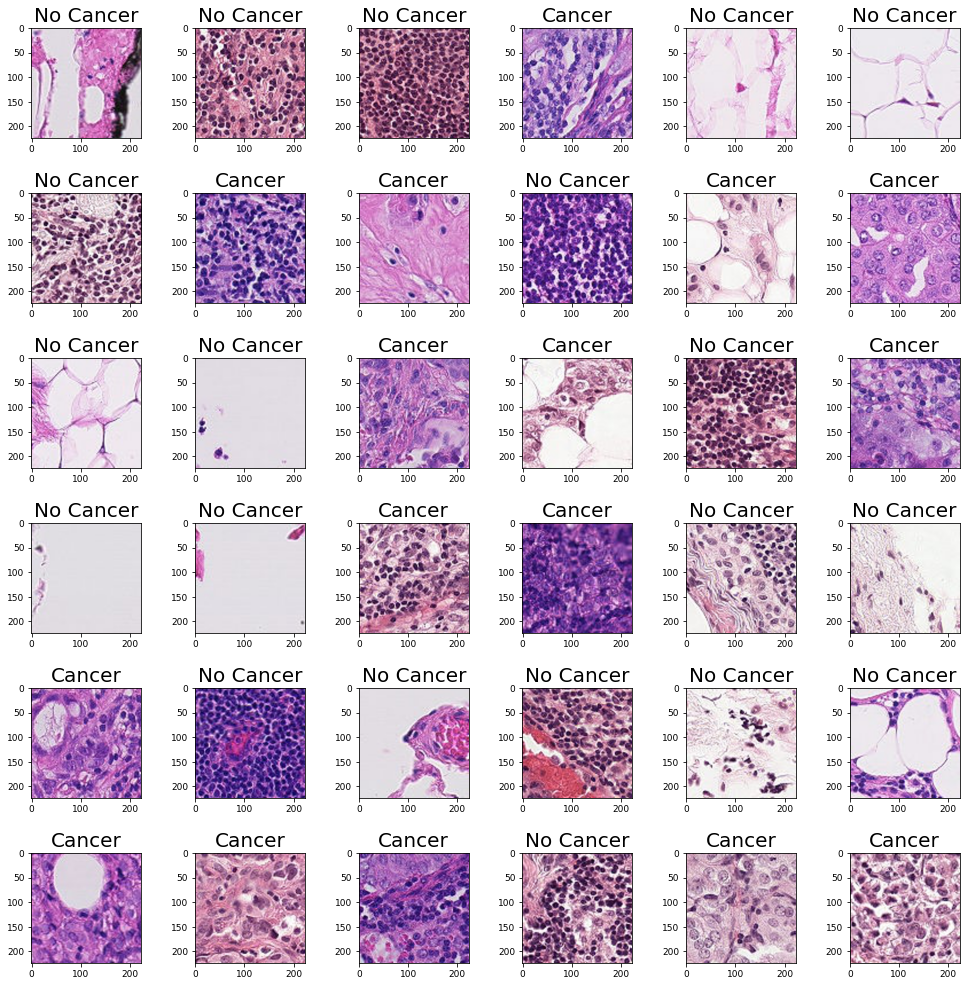

In [16]:
import cv2
rows=6
cols=6
label_converter = {0: 'No Cancer', 1: 'Cancer'}
fig, axs = plt.subplots(rows, cols, figsize=(14, 14))
axs = axs.flatten()
for (img, img_label), ax in zip(zip(image, image_label), axs):
    ax.imshow(img)
    ax.set_title(label_converter[img_label], fontsize=20)
    fig.tight_layout(pad=2.0)

plt.show()

# 3. Models Training and Inference
## 3.1. ViTransformer

### 3.1.1. Loading ViT Feature Extractor

In [17]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor(do_resize=False).from_pretrained(model_name_or_path)

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

To process an image, simply pass it to the feature extractor's call function. This will return a dict containing pixel values, which is the numeric representation to be passed to the model.
<br>We got a NumPy array by default, but if we add the return_tensors='pt' argument, we'll get back torch tensors instead.</br>

### 3.1.2. Processing the data set
We know how to read images and transform them into inputs, now we have to write a function that will put those two things together to process a single example from the dataset.

In [18]:
def process_example(example):
    inputs = feature_extractor(example['image'], return_tensors='pt')
    inputs['labels'] = example['labels']
    return inputs

def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['labels']
    return inputs

In [19]:
prepared_ds = ds.with_transform(transform)

In [20]:
# with open('/kaggle/working/dataset_224x224.pkl', 'wb') as file:
#     pickle.dump(prepared_ds, file)

### Training and Evaluation

The data is processed and we are ready to start setting up the training pipeline. We are going to use `Trainer`, that'll require 

- Define a collate function.

- Define an evaluation metric. During training, the model should be evaluated on its prediction accuracy. We should define a `compute_metrics` function accordingly.

- Load a pretrained checkpoint. We need to load a pretrained checkpoint and configure it correctly for training.

- Define the training configuration.

After fine-tuning the model, we will correctly evaluate it on the evaluation data and verify that it has indeed learned to correctly classify the images.

### Define our data collator
Batches are coming in as lists of dicts, so we can just unpack + stack those into batch tensors.
<br>Since the `collate_fn` will return a batch dict, we can unpack the inputs to the model later</br>

In [21]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

### Define an evaluation metric

The accuracy metric from datasets can easily be used to compare the predictions with the labels. 
<br>Below, we can see how to use it within a `compute_metrics` function that will be used by the `Trainer`.</br>

In [22]:
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1),
                          references=p.label_ids)

### Load model
Next we'll add the pretrained model. We'll add `num_labels` on init so the model creates a classification head (last layer of the neuron network) with the right number of units. 

In [23]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={'0': 'No Cancer', '1': 'Cancer'},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 3.1.3. Setting up the training configuration by defining `TrainingArguments`.

In [24]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./fine_tuned_ViT",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=10,
  #fp16=False,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

### 3.1.4. Set up `Trainer`
Now, all instances can be passed to `Trainer` and we are ready to start training!

In [25]:
from transformers import EarlyStoppingCallback
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds['train'],
    eval_dataset=prepared_ds['eval'],
    tokenizer=feature_extractor,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=10)]
)

Using cuda_amp half precision backend


### 3.1.5. Train model

In [26]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 8000
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 2500
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Accuracy
100,0.285500,0.285849,0.889000
200,0.241000,0.275254,0.909000
300,0.179900,0.253682,0.903000
400,0.149100,0.272976,0.906000
500,0.179500,0.258872,0.901000
600,0.081700,0.289230,0.914000
700,0.072100,0.300914,0.897000
800,0.102300,0.286034,0.916000
900,0.089600,0.364563,0.902000
1000,0.038500,0.341265,0.913000


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 16
Saving model checkpoint to ./fine_tuned_ViT/checkpoint-100
Configuration saved in ./fine_tuned_ViT/checkpoint-100/config.json
Model weights saved in ./fine_tuned_ViT/checkpoint-100/pytorch_model.bin
Feature extractor saved in ./fine_tuned_ViT/checkpoint-100/preprocessor_config.json
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 16
Saving model checkpoint to ./fine_tuned_ViT/checkpoint-200
Configuration saved in ./fine_tuned_ViT/checkpoint-200/config.json
Model weights saved in ./fine_tuned_ViT/checkpoint-200/pytorch_model.bin
Feature extractor saved in ./fine_tuned_ViT/checkpoint-200/preprocessor_config.json
/opt/conda/lib/pyth

***** train metrics *****
  epoch                    =          5.2
  total_flos               = 3002273634GF
  train_loss               =       0.1318
  train_runtime            =   0:13:21.24
  train_samples_per_second =       99.845
  train_steps_per_second   =         3.12


### Evaluate

In [27]:
metrics = trainer.evaluate(prepared_ds['eval'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 1000
  Batch size = 16
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


***** eval metrics *****
  epoch                   =        5.2
  eval_accuracy           =      0.903
  eval_loss               =     0.2537
  eval_runtime            = 0:00:09.23
  eval_samples_per_second =    108.253
  eval_steps_per_second   =       6.82


### 3.1.6. Plot training

In [28]:
import json
train_state_ViT = json.load(open('/kaggle/working/fine_tuned_ViT/trainer_state.json', 'r'))
# train_state['log_history'] is a dictionary which saved validation loss and accuracy

In [29]:
df_loss_ViT = pd.DataFrame.from_dict(train_state_ViT['log_history'])
df_loss_ViT

,epoch,learning_rate,loss,step,eval_accuracy,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,total_flos,train_loss,train_runtime,train_samples_per_second,train_steps_per_second
0,0.04,0.000199,0.5273,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.08,0.000198,0.4688,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.12,0.000198,0.4321,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.16,0.000197,0.3788,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.20,0.000196,0.3225,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,5.12,0.000098,0.0044,1280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
140,5.16,0.000097,0.0232,1290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141,5.20,0.000096,0.0024,1300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
142,5.20,NaN,NaN,1300,0.913,0.365565,9.5713,104.479,6.582,NaN,NaN,NaN,NaN,NaN


### a. Train loss, Validation loss graph

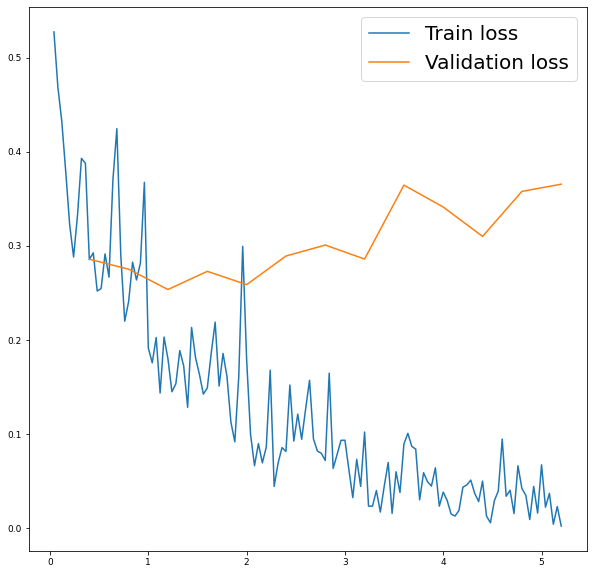

In [30]:
plt.plot(df_loss_ViT.loc[df_loss_ViT['loss'].isnull() == False, 'epoch'], 
         df_loss_ViT.loc[df_loss_ViT['loss'].isnull() == False, 'loss'])
plt.plot(df_loss_ViT.loc[df_loss_ViT['eval_loss'].isnull() == False, 'epoch'],
         df_loss_ViT.loc[df_loss_ViT['eval_loss'].isnull() == False,'eval_loss'])
plt.legend(['Train loss', 'Validation loss'], fontsize=20);
plt.show()

### b. Validation accuracy graph

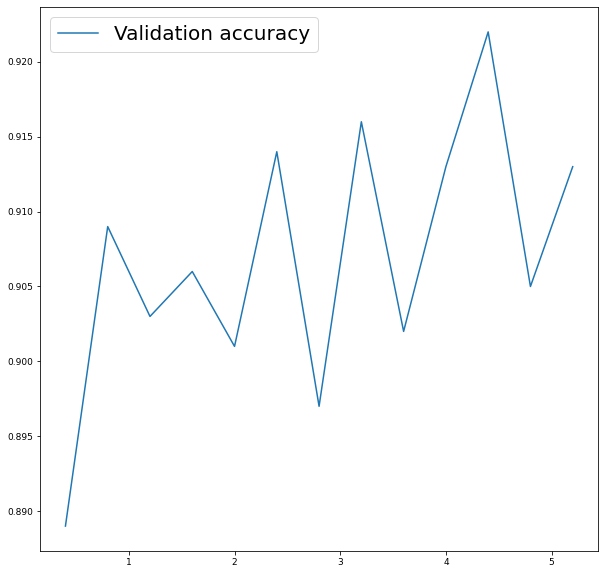

In [31]:
plt.plot(df_loss_ViT.loc[df_loss_ViT['eval_accuracy'].isnull() == False, 'epoch'], 
         df_loss_ViT.loc[df_loss_ViT['eval_accuracy'].isnull() == False, 'eval_accuracy'])
plt.legend(['Validation accuracy'], fontsize=20);
plt.show()

### c. Test

In [32]:
prepared_test = ds['test'].with_transform(transform)

In [33]:
metrics = trainer.evaluate(prepared_test)
trainer.log_metrics("test", metrics)
trainer.save_metrics("test", metrics)

***** Running Evaluation *****
  Num examples = 1000
  Batch size = 16
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


***** test metrics *****
  epoch                   =        5.2
  eval_accuracy           =        0.9
  eval_loss               =     0.2514
  eval_runtime            = 0:00:09.15
  eval_samples_per_second =     109.24
  eval_steps_per_second   =      6.882


In [34]:
# from transformers import ViTFeatureExtractor, ViTForImageClassification
# import torch
# from datasets import load_dataset

# image = test_ds["image"][0]

# feature_extractor = ViTFeatureExtractor.from_pretrained("/kaggle/working/fine_tuned_ViT")
# model = ViTForImageClassification.from_pretrained("/kaggle/working/fine_tuned_ViT")

# inputs = feature_extractor(image, return_tensors="pt")

# with torch.no_grad():
#     logits = model(**inputs).logits

# predicted_label = logits.argmax(-1).item()
# print(model.config.id2label[predicted_label])

In [35]:
model = ViTForImageClassification.from_pretrained("/kaggle/working/fine_tuned_ViT")
feature_extractor = ViTFeatureExtractor.from_pretrained("/kaggle/working/fine_tuned_ViT")

preds_ViT_ = []
# Create a list to save the results of model's prediction

for i in trange(len(test_ds['image'])):
    image = test_ds['image'][i]
    inputs = feature_extractor(image, return_tensors="pt")

    with torch.no_grad():
        logits = model(**inputs).logits
    
    predicted_label = logits.argmax(-1).item()
    preds_ViT_.append(predicted_label)
#     print(model.config.id2label[predicted_label])

loading configuration file /kaggle/working/fine_tuned_ViT/config.json
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "No Cancer",
    "1": "Cancer"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "0": "1",
    "1": "0"
  },
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "problem_type": "single_label_classification",
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.20.1"
}

loading weights file /kaggle/working/fine_tuned_ViT/pytorch_model.bin
All model checkpoint weights were used when initializing ViTForImageClassification.

All the weights of ViTForIm

### 3.1.7. Compute metrics

In [36]:
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, f1, support = score(test_ds['labels'], preds_ViT_, average='macro')
accuracy = metrics["eval_accuracy"]

print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1-score: {f1}')
print(f'accuracy: {accuracy}')

precision: 0.9069450277503059
recall: 0.8813343433018352
f1-score: 0.8910917399619256
accuracy: 0.9


In [37]:
# Save metrics in a dataframe
compare_df = pd.DataFrame(columns=['Metrics', 'ViT', 'ConvNeXt'])
compare_df['Metrics'] = ['Precision', 'Recall', 'F1-score', 'Accuracy']
compare_df['ViT'] = [precision, recall, f1, accuracy]

### 3.1.8. Confusion matrix 

In [38]:
# Create plot_confusion_matrix function
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm,classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    
    plt.figure(figsize=(15,10))
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45,fontsize=15)
    plt.yticks(tick_marks,classes,fontsize=15,rotation=90)

    if normalize:
        cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        cm=np.around(cm,decimals=2)
        cm[np.isnan(cm)]=0.0
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')
    thresh=cm.max()/2

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):

        plt.text(j, i, cm[i, j],
                horizontalalignment="center",fontsize=15,
                color="white" if cm[i, j] > thresh else "black")
        plt.tight_layout()
        plt.ylabel('True label',fontsize=20)
        plt.xlabel('Predicted label',fontsize=20)

    plt.grid(False)


In [39]:
# Calculate confusion_matrix_ViT
from sklearn.metrics import confusion_matrix

confusion_matrix_ViT = confusion_matrix(test_ds['labels'], preds_ViT_)
confusion_matrix_ViT

array([[593,  24],
       [ 76, 307]])

Normalized confusion matrix


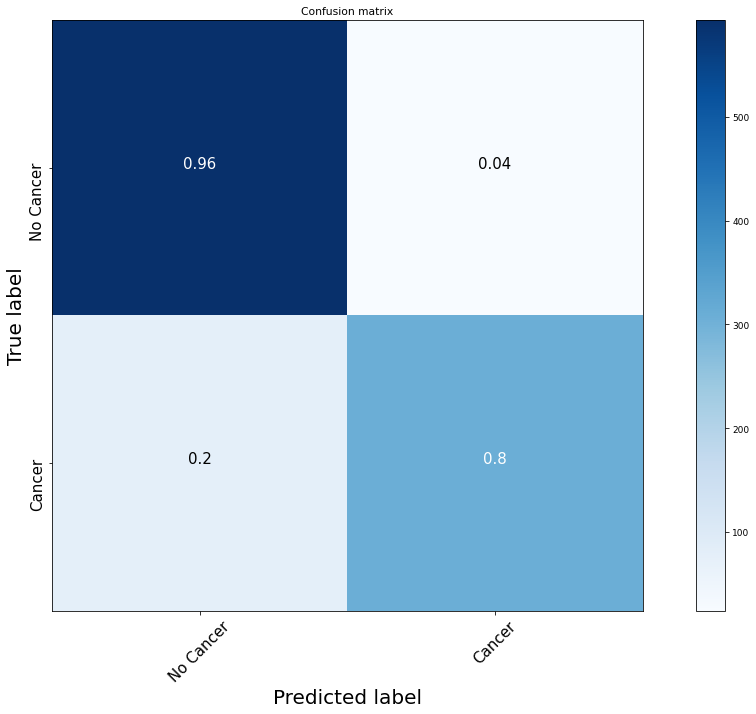

In [40]:
plot_confusion_matrix(confusion_matrix_ViT, ['No Cancer','Cancer'],normalize=True,title='Confusion matrix',cmap=plt.cm.Blues)

## 3.2. ConvNeXt Model
The data processing and configuration part is the same as ViT, just change a litle bit at the model path and

### 3.2.1. Loading ConvNeXt Feature Extractor

In [41]:
from transformers import ConvNextFeatureExtractor

model_name_or_path = 'facebook/convnext-tiny-224'
feature_extractor =  ConvNextFeatureExtractor(do_resize=False).from_pretrained(model_name_or_path)

https://huggingface.co/facebook/convnext-tiny-224/resolve/main/preprocessor_config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpdz8c24tl


Downloading:   0%|          | 0.00/266 [00:00<?, ?B/s]

storing https://huggingface.co/facebook/convnext-tiny-224/resolve/main/preprocessor_config.json in cache at /root/.cache/huggingface/transformers/9680dfbfa38989323a5ae0b86951c5860c092e3aae6dc354483c075fee48c1a1.37be7274d6b5860aee104bb1fbaeb0722fec3850a85bb2557ae9491f17f89433
creating metadata file for /root/.cache/huggingface/transformers/9680dfbfa38989323a5ae0b86951c5860c092e3aae6dc354483c075fee48c1a1.37be7274d6b5860aee104bb1fbaeb0722fec3850a85bb2557ae9491f17f89433
loading feature extractor configuration file https://huggingface.co/facebook/convnext-tiny-224/resolve/main/preprocessor_config.json from cache at /root/.cache/huggingface/transformers/9680dfbfa38989323a5ae0b86951c5860c092e3aae6dc354483c075fee48c1a1.37be7274d6b5860aee104bb1fbaeb0722fec3850a85bb2557ae9491f17f89433
Feature extractor ConvNextFeatureExtractor {
  "crop_pct": 0.875,
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ConvNextFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.4

In [42]:
id2label = {'0':'No Cancer', '1':'Cancer'}
label2id = {v:k for k,v in enumerate(labels)}

### 3.2.2. Processing the data set
We know how to read images and transform them into inputs, now we have to write a function that will put those two things together to process a single example from the dataset.

In [43]:
def process_example(example):
    inputs = feature_extractor(example['image'], return_tensors='pt')
    inputs['labels'] = example['labels']
    return inputs
def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')

    inputs['labels'] = example_batch['labels']
    return inputs

In [44]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)


In [45]:
prepared_ds = ds.with_transform(transform)

### 3.2.3. Load model
Next we'll add the pretrained model. We'll add `num_labels` on init so the model creates a classification head with the right number of units. 

In [46]:
from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained("facebook/convnext-tiny-224",
                                                        num_labels=len(labels),
                                                        id2label=id2label,
                                                        label2id=label2id,
                                                        ignore_mismatched_sizes=True)

https://huggingface.co/facebook/convnext-tiny-224/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp60e0ok9y


Downloading:   0%|          | 0.00/68.0k [00:00<?, ?B/s]

storing https://huggingface.co/facebook/convnext-tiny-224/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/741b590dfc3966dd77875cd496d6f9097645132a8e8106ab873b7d130da4cab9.fba866a30db31ba0d3bb63ddbdaccc3ba609c530ee38ca0150a68f3c9a8d6ccf
creating metadata file for /root/.cache/huggingface/transformers/741b590dfc3966dd77875cd496d6f9097645132a8e8106ab873b7d130da4cab9.fba866a30db31ba0d3bb63ddbdaccc3ba609c530ee38ca0150a68f3c9a8d6ccf
loading configuration file https://huggingface.co/facebook/convnext-tiny-224/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/741b590dfc3966dd77875cd496d6f9097645132a8e8106ab873b7d130da4cab9.fba866a30db31ba0d3bb63ddbdaccc3ba609c530ee38ca0150a68f3c9a8d6ccf
Model config ConvNextConfig {
  "_name_or_path": "facebook/convnext-tiny-224",
  "architectures": [
    "ConvNextForImageClassification"
  ],
  "depths": [
    3,
    3,
    9,
    3
  ],
  "drop_path_rate": 0.0,
  "hidden_act": "gelu",
  "hidden_sizes": [
 

Downloading:   0%|          | 0.00/109M [00:00<?, ?B/s]

storing https://huggingface.co/facebook/convnext-tiny-224/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/f6cde2591c44e990d97372da4184ff364f9270bd3e051a10e9ebc7f077b2c276.6164ec88009a0d416d211404f7a5feaafb35327b50613e99aec53791a3daabdc
creating metadata file for /root/.cache/huggingface/transformers/f6cde2591c44e990d97372da4184ff364f9270bd3e051a10e9ebc7f077b2c276.6164ec88009a0d416d211404f7a5feaafb35327b50613e99aec53791a3daabdc
loading weights file https://huggingface.co/facebook/convnext-tiny-224/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/f6cde2591c44e990d97372da4184ff364f9270bd3e051a10e9ebc7f077b2c276.6164ec88009a0d416d211404f7a5feaafb35327b50613e99aec53791a3daabdc
All model checkpoint weights were used when initializing ConvNextForImageClassification.

Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-tiny-224 and are newly initialized because the 

### 3.2.4. Setting up the training configuration by defining `TrainingArguments`.

In [47]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./fine_tuned_convnext",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=10,
  #fp16=False,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True, # prevent model from overfitting
)

PyTorch: setting up devices


### 3.2.5. Set up `Trainer`
Now, all instances can be passed to `Trainer` and we are ready to start training!

In [48]:
from transformers import EarlyStoppingCallback
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds['train'],
    eval_dataset=prepared_ds['eval'],
    tokenizer=feature_extractor,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=10)] # prevent model from overfitting

)

Using cuda_amp half precision backend


### 3.2.6. Train Model

In [49]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 8000
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 2500
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Accuracy
100,0.279100,0.288993,0.882000
200,0.209100,0.267645,0.892000
300,0.215300,0.237459,0.913000
400,0.137400,0.276557,0.910000
500,0.151600,0.231606,0.917000
600,0.073800,0.306884,0.915000
700,0.094100,0.354173,0.895000
800,0.039200,0.376154,0.905000
900,0.015200,0.375009,0.911000
1000,0.025800,0.437359,0.921000


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 16
Saving model checkpoint to ./fine_tuned_convnext/checkpoint-100
Configuration saved in ./fine_tuned_convnext/checkpoint-100/config.json
Model weights saved in ./fine_tuned_convnext/checkpoint-100/pytorch_model.bin
Feature extractor saved in ./fine_tuned_convnext/checkpoint-100/preprocessor_config.json
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 16
Saving model checkpoint to ./fine_tuned_convnext/checkpoint-200
Configuration saved in ./fine_tuned_convnext/checkpoint-200/config.json
Model weights saved in ./fine_tuned_convnext/checkpoint-200/pytorch_model.bin
Feature extractor saved in ./fine_tuned_convnext/checkpoint-200/prep

***** train metrics *****
  epoch                    =          6.0
  total_flos               = 1123292972GF
  train_loss               =       0.1007
  train_runtime            =   0:12:02.37
  train_samples_per_second =      110.745
  train_steps_per_second   =        3.461


### 3.2.7. Evaluate

In [50]:
metrics = trainer.evaluate(prepared_ds['eval'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 1000
  Batch size = 16
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


***** eval metrics *****
  epoch                   =        6.0
  eval_accuracy           =      0.917
  eval_loss               =     0.2316
  eval_runtime            = 0:00:09.37
  eval_samples_per_second =    106.653
  eval_steps_per_second   =      6.719


### 3.2.8. Plot training

In [51]:
import json
train_state_ConvNeXt = json.load(open('/kaggle/working/fine_tuned_convnext/trainer_state.json', 'r'))

In [52]:
df_loss_ConvNeXt = pd.DataFrame.from_dict(train_state_ConvNeXt['log_history'])
df_loss_ConvNeXt

,epoch,learning_rate,loss,step,eval_accuracy,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,total_flos,train_loss,train_runtime,train_samples_per_second,train_steps_per_second
0,0.04,0.000199,0.5371,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.08,0.000198,0.4565,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.12,0.000198,0.4352,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.16,0.000197,0.3619,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.20,0.000196,0.3243,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,5.92,0.000082,0.0036,1480,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
162,5.96,0.000081,0.0019,1490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
163,6.00,0.000080,0.0182,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
164,6.00,NaN,NaN,1500,0.923,0.513322,9.1492,109.299,6.886,NaN,NaN,NaN,NaN,NaN


### a. Train loss, Validation loss graph

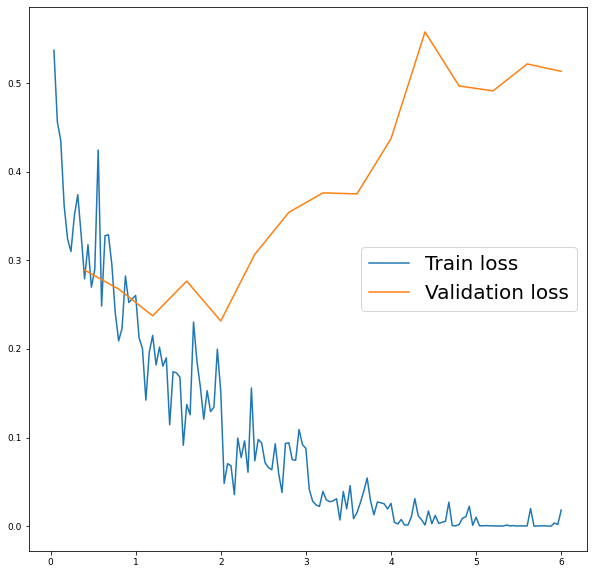

In [53]:
plt.plot(df_loss_ConvNeXt.loc[df_loss_ConvNeXt['loss'].isnull() == False, 'epoch'],
         df_loss_ConvNeXt.loc[df_loss_ConvNeXt['loss'].isnull() == False, 'loss'])
plt.plot(df_loss_ConvNeXt.loc[df_loss_ConvNeXt['eval_loss'].isnull() == False, 'epoch'],
         df_loss_ConvNeXt.loc[df_loss_ConvNeXt['eval_loss'].isnull() == False,'eval_loss'])
plt.legend(['Train loss', 'Validation loss'], fontsize=20);
plt.show()

### b. Validation accuracy graph

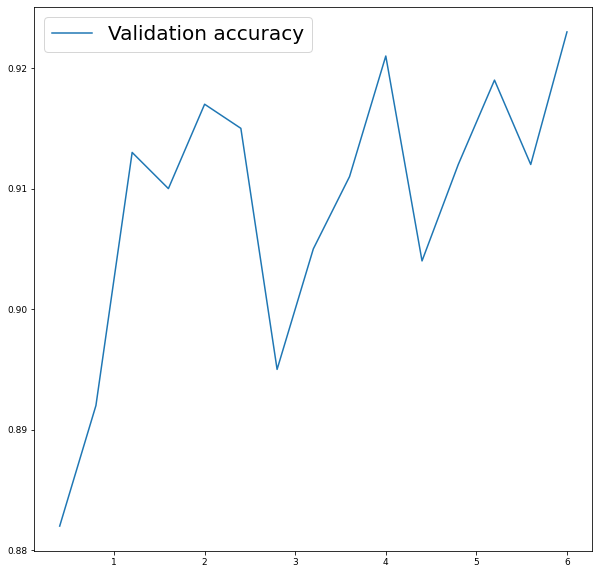

In [54]:
plt.plot(df_loss_ConvNeXt.loc[df_loss_ConvNeXt['eval_accuracy'].isnull() == False, 'epoch'], df_loss_ConvNeXt.loc[df_loss_ConvNeXt['eval_accuracy'].isnull() == False, 'eval_accuracy'])
plt.legend(['Validation accuracy'], fontsize=20);
plt.show()

### c. Test

In [55]:
prepared_test = ds['test'].with_transform(transform)

In [56]:
metrics = trainer.evaluate(prepared_test)
trainer.log_metrics("test", metrics)
trainer.save_metrics("test", metrics)

***** Running Evaluation *****
  Num examples = 1000
  Batch size = 16
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


***** test metrics *****
  epoch                   =        6.0
  eval_accuracy           =      0.928
  eval_loss               =     0.2229
  eval_runtime            = 0:00:09.14
  eval_samples_per_second =    109.292
  eval_steps_per_second   =      6.885


In [57]:
model = AutoModelForImageClassification.from_pretrained("/kaggle/working/fine_tuned_convnext")
feature_extractor = ConvNextFeatureExtractor(do_resize=False).from_pretrained("/kaggle/working/fine_tuned_convnext")

preds_ConvNeXt_ =[]
# Create a list to save the results of model's prediction

for i in trange(len(test_ds['image'])):
    image = test_ds['image'][i]
    inputs = feature_extractor(image, return_tensors="pt")

    with torch.no_grad():
        logits = model(**inputs).logits
    
    predicted_label = logits.argmax(-1).item()
    preds_ConvNeXt_.append(predicted_label)
#     print(model.config.id2label[predicted_label])

loading configuration file /kaggle/working/fine_tuned_convnext/config.json
Model config ConvNextConfig {
  "_name_or_path": "/kaggle/working/fine_tuned_convnext",
  "architectures": [
    "ConvNextForImageClassification"
  ],
  "depths": [
    3,
    3,
    9,
    3
  ],
  "drop_path_rate": 0.0,
  "hidden_act": "gelu",
  "hidden_sizes": [
    96,
    192,
    384,
    768
  ],
  "id2label": {
    "0": "No Cancer",
    "1": "Cancer"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "label2id": {
    "0": 1,
    "1": 0
  },
  "layer_norm_eps": 1e-12,
  "layer_scale_init_value": 1e-06,
  "model_type": "convnext",
  "num_channels": 3,
  "num_stages": 4,
  "patch_size": 4,
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.20.1"
}

loading weights file /kaggle/working/fine_tuned_convnext/pytorch_model.bin
All model checkpoint weights were used when initializing ConvNextForImageClassification.

All the weights of ConvNextForImageC

### 3.2.9. Compute metrics

In [58]:
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, f1, support = score(test_ds['labels'], preds_ConvNeXt_, average='macro')
accuracy = metrics["eval_accuracy"]

print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1-score: {f1}')
print(f'accuracy: {accuracy}')

compare_df['ConvNeXt'] = [precision, recall, f1, accuracy]

precision: 0.9275806277639953
recall: 0.91937319887775
f1-score: 0.923117664143787
accuracy: 0.928


### 3.2.10. Confusion matrix

In [59]:
# Calculate confusion_matrix_ConvNeXt
confusion_matrix_ConvNeXt = confusion_matrix(test_ds['labels'], preds_ConvNeXt_)
confusion_matrix_ConvNeXt

array([[590,  27],
       [ 45, 338]])

Normalized confusion matrix


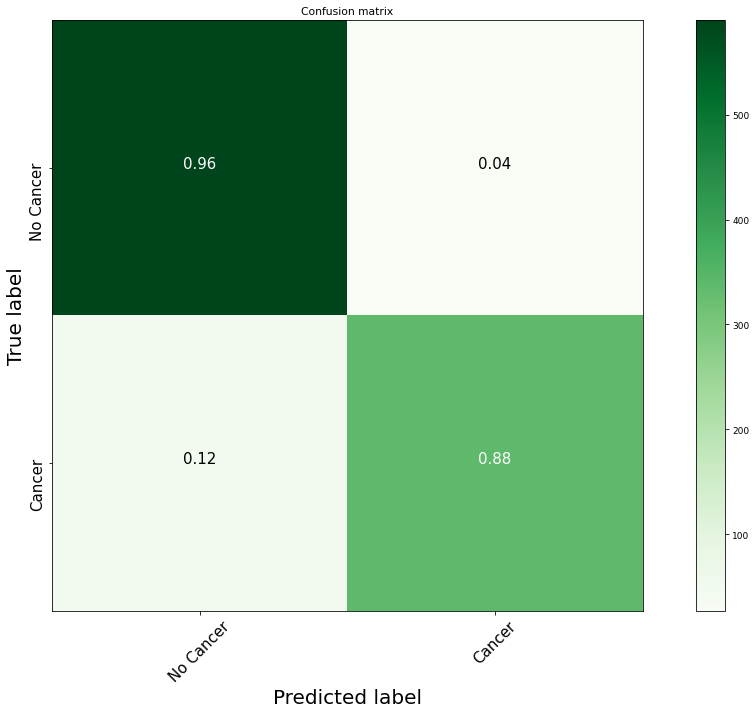

In [60]:
# Plot confusion matrix graph
plot_confusion_matrix(confusion_matrix_ConvNeXt, ['No Cancer','Cancer'],
                      normalize=True,title='Confusion matrix',cmap=plt.cm.Greens)

# 4. Performance comparison between ViT and ConvNeXt

In [61]:
compare_df.set_index('Metrics')

,ViT,ConvNeXt
Metrics,,
Precision,0.906945,0.927581
Recall,0.881334,0.919373
F1-score,0.891092,0.923118
Accuracy,0.900000,0.928000


# 5. Limitation

### We already had quite high accuracy models despite of some limitations:
- Limited time
- Small training set (10,000 images compared to original:  220,000 images)
- Limited resources (GPU, CPU, RAM)

If we can overcome these limitations, we can improve our accuracy can be implemented in Medical Services (Cancerous Tumors Diagnosis)


# 6. Learning outcome from the project

There was some cons of us due to lack of knowledge, we need to research so much and try so much to get the result. It took much time but on the way we learn really many new things 

After the project, we **gain a lot of skills** through hard problem:
- Know how to prepare the dataset to suit the problem, process the data set to feed into machine learning model
- Know how to fine-tune a **deep learning model - computer vision**: Vision Transformer, ConvNeXT
- Work as a team, know how to **debug** others' code and learn how to **code a clean code**
- Know how to optimum the model, prevent model from **overfitting** and **get the best model** that we can get
- Know how to **approach a new machine learning model**, how to use it, how it works by **researching, reading papers**

# 7. Thank you